In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler


Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='version1'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/train.zip') #
data.shape

(8650, 315)

In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid276,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,path-timestamp
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-80,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934464983
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-80,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934467125
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934469251
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02-1633934471370
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,record_2021_10_11_07_41_02-1633934473508


In [ ]:
print('split path-timestamp in 2 columns')
data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
print('remove path-timestamp column')
data.drop('path-timestamp', axis=1,inplace=True)

split path-timestamp in 2 columns
remove path-timestamp column


In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,path,timestamp
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934464983
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934467125
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934469251
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,record_2021_10_11_07_41_02,1633934471370
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,record_2021_10_11_07_41_02,1633934473508


In [ ]:
TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
len(TRAIN_FEATS)

312

In [ ]:
d2=data.loc[:,TRAIN_FEATS].copy()
d2[d2==-999]=0
d2[d2!=0]=1

In [ ]:
d2.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid273,rsid274,rsid275,rsid276,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


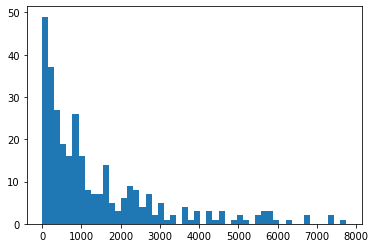

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.sum(d2,0),50)
plt.show()

In [ ]:

Ms=np.mean(data.loc[:,TRAIN_FEATS].values,axis=0)
Ss=np.std(data.loc[:,TRAIN_FEATS].values,axis=0)

# joblib.dump(Ms,'means_of_rssids2')
# joblib.dump(Ss,'stds_of_rssids2')

for i in range(len(TRAIN_FEATS)):
    data.loc[:,TRAIN_FEATS[i]] = (data.loc[:,TRAIN_FEATS[i]] - Ms[i])/(Ss[i]+1)

In [ ]:
unpaths=data.path.unique()

In [ ]:
print('we have ',len(unpaths),' unique paths')

we have  254  unique paths


In [ ]:
USE_FEATS=TRAIN_FEATS[:]
# USE_FEATS=np.array(TRAIN_FEATS)[np.where((np.sum(d2,0))>200)[0]]
USE_FEATS.shape

AttributeError: ignored

### CV TRAIN

In [ ]:

def create_model(rssi_size):
            
    # input_layer_all = L.Input(shape=(rssi_size,), name='inputL', dtype='float32')
    input_layer = L.Input(shape=(rssi_size,), name='inputL')

    # input_layer = L.Input((rssi_size, ), name='input_rsid', dtype='float32')
    x = L.BatchNormalization(name='bn1')(input_layer)
    x = L.Dense(256, name='dn1', activation='relu')(x)
    
    x = L.BatchNormalization(name='bn2')(x)
    x = L.Dropout(0.3, name='do2')(x)
    x = L.Dense(256, name='dn2', activation='relu')(x)


    # x = L.BatchNormalization()(x)
    # x = L.Dropout(0.3)(x)
    # x = L.Dense(256, activation='relu')(x)
    # x = L.Dropout(0.3)(x)


    x = L.Reshape((1 , 256), name='resh')(x)
#     x = L.Reshape((1 , -1))(x)
    # print(x.shape)
    x = L.BatchNormalization(name='bn3')(x)
    x = L.LSTM(128, return_sequences=True, name='lstm1')(x)
    x = L.Dropout(0.2, name='do3')(x)
    x = L.BatchNormalization(name='bn4')(x)    
    x = L.LSTM(64, return_sequences=True, name='lstm2')(x)
    x = L.Dropout(0.1, name='do4')(x)
#     x = L.Bidirectional(L.LSTM(512, return_sequences=True))(x)
#     x = L.BatchNormalization()(x)    
#     x = L.Bidirectional(L.LSTM(256, return_sequences=True))(x)    
    x = L.BatchNormalization(name='bn5')(x)
    x = L.LSTM(32, return_sequences=False, name='lstm3')(x)
    # x = L.LSTM(128, return_sequences=False, name='lstm3')(x)
    # x = L.Dropout(0.1)(x)
    # print(x.shape)
    
    
    x = L.BatchNormalization(name='bn6')(x)
#     x = L.Dropout(0.1)(x)
#     x = L.Dense(64)(x)
# #     x = L.Dropout(0.1)(x)
#     x = L.Dense(128)(x)
# #     x = L.Dense(64, activation='relu')(x)

    output_layer = L.Dense(2, name='xy')(x)

    model = M.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss='mse', metrics=['mse'])

    return model    
model =  create_model(rssi_size=len(TRAIN_FEATS) )
model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputL (InputLayer)         [(None, 312)]             0         
                                                                 
 bn1 (BatchNormalization)    (None, 312)               1248      
                                                                 
 dn1 (Dense)                 (None, 256)               80128     
                                                                 
 bn2 (BatchNormalization)    (None, 256)               1024      
                                                                 
 do2 (Dropout)               (None, 256)               0         
                                                                 
 dn2 (Dense)                 (None, 256)               65792     
                                                                 
 resh (Reshape)              (None, 1, 256)            0  

In [ ]:
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)

In [ ]:
# CROSS VALIDATION

name='keras'+version


score_df = pd.DataFrame()
oof = list()
predictions = list()

oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
preds_x, preds_y = 0, 0

scores_per_fold=[]

all_preds=[]
all_targets=[]

np.random.seed(42)
sh=np.random.permutation(unpaths)


k=5
val_size=int(len(sh)/k)
for f in range(k):
    print('fold:', f)

    if f<(k-1):
        val_paths=sh[val_size*f:val_size*(f+1)]
    else:
        val_paths=sh[val_size*f:]

    train_paths=[x for x in unpaths if x not in val_paths]
    
    val_paths=np.array(val_paths)
    train_paths=np.array(train_paths)
    
    X_train = data.loc[data.path.isin(train_paths), USE_FEATS ].reset_index(drop=True).values

    y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

    X_val = data.loc[data.path.isin(val_paths), USE_FEATS ].reset_index(drop=True).values
    y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values



    model = create_model(rssi_size=len(USE_FEATS) )
    epochs=100
    snapshots = 5
    lr_0 = 0.01
    lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

    h = model.fit(X_train, y_train, 
                batch_size=128*8, epochs=epochs, verbose=0,
                  validation_data=(X_val, y_val),
                callbacks=[ lr_anneal1
            ])
    
    epochs=100
    snapshots = 5
    lr_0 = 0.001
    lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

    h = model.fit(X_train, y_train, 
                batch_size=128*8, epochs=epochs, verbose=0,
                  validation_data=(X_val, y_val),
                callbacks=[ lr_anneal1
            ])
    model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
    val_predsXY = model.predict(X_val)

    
    print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

    all_preds.append(val_predsXY)
    all_targets.append(y_val)
        

all_predsV=np.vstack(all_preds)
all_targetsV=np.vstack(all_targets)    

fold: 0
2.268973854013287
fold: 1
2.6432776981104062
fold: 2
2.377564214525997
fold: 3
2.4936781839774635
fold: 4
2.3723903745206987


In [ ]:
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

mean validation error, 5-fold 2.432263368828622


In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/keras_oof.csv.gz', index=False, compression='gzip')
pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV.csv.gz', index=False, compression='gzip')

## EVALUATION - PLOTS

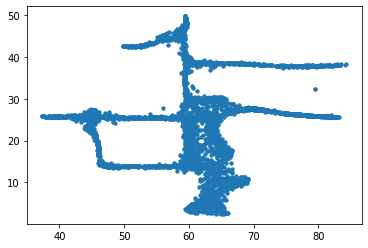

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

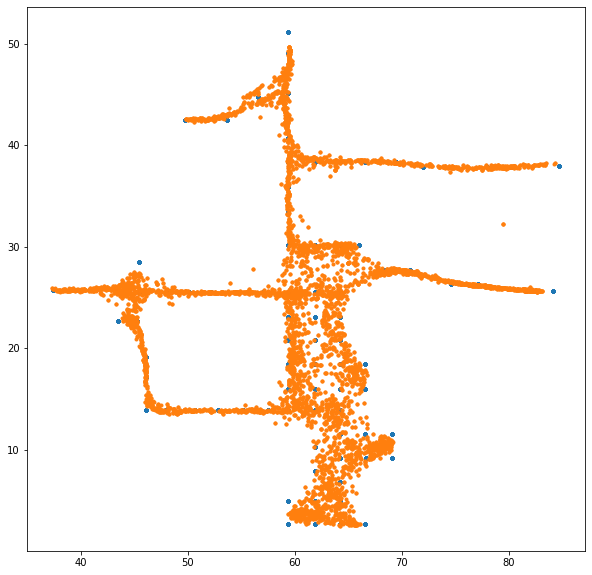

mean validation error, 5-fold 2.432263368828622


In [ ]:
plt.figure(figsize=(10,10))
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'.')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

## Full train

In [ ]:


name='keras'+version

train_paths=unpaths[:]

train_paths=np.array(train_paths)
X_train = data.loc[data.path.isin(train_paths), USE_FEATS ].reset_index(drop=True).values

y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

model = create_model(rssi_size=len(USE_FEATS) )
epochs=100
snapshots = 5
lr_0 = 0.01
lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

h = model.fit(X_train, y_train, 
            batch_size=128*8, epochs=epochs, verbose=1,
            callbacks=[ lr_anneal1
        ])

epochs=100
snapshots = 5
lr_0 = 0.001
lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

h = model.fit(X_train, y_train, 
            batch_size=128*8, epochs=epochs, verbose=1,
            callbacks=[ lr_anneal1
        ])
model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
train_predsXY = model.predict(X_train)


print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_train[:,0], y_train[:,1]))


Epoch 1/100
9/9 [==============================] - 10s 86ms/step - loss: 2201.5308 - mse: 2201.5308 - lr: 0.0100
Epoch 2/100
9/9 [==============================] - 1s 85ms/step - loss: 2094.5972 - mse: 2094.5972 - lr: 0.0099
Epoch 3/100
9/9 [==============================] - 1s 83ms/step - loss: 1969.3054 - mse: 1969.3054 - lr: 0.0098
Epoch 4/100
9/9 [==============================] - 1s 83ms/step - loss: 1802.8193 - mse: 1802.8193 - lr: 0.0095
Epoch 5/100
9/9 [==============================] - 1s 84ms/step - loss: 1592.2478 - mse: 1592.2478 - lr: 0.0090
Epoch 6/100
9/9 [==============================] - 1s 85ms/step - loss: 1351.5800 - mse: 1351.5800 - lr: 0.0085
Epoch 7/100
9/9 [==============================] - 1s 85ms/step - loss: 1104.0033 - mse: 1104.0033 - lr: 0.0079
Epoch 8/100
9/9 [==============================] - 1s 83ms/step - loss: 873.8869 - mse: 873.8869 - lr: 0.0073
Epoch 9/100
9/9 [==============================] - 1s 84ms/step - loss: 677.2028 - mse: 677.2028 - lr: 0.